# DACON 서울 랜드마크 이미지 분류 경진대회
## 1. 패키지

In [2]:
import warnings
warnings.filterwarnings('ignore')

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
from glob import glob
from tqdm.notebook import tqdm

import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

In [3]:
img_size = 128

lr = 0.01
n_epochs = 50
batch_size = 16

## 2. 데이터 확인

In [4]:
train_dir = './dataset/train'
test_dir = './dataset/test'

In [5]:
# train label check
label_df = pd.read_csv('./dataset/train.csv')
label_df.head()

,file_name,label
0,001.PNG,9
1,002.PNG,4
2,003.PNG,1
3,004.PNG,1
4,005.PNG,6


In [6]:
label_df['label'].unique()

array([9, 4, 1, 6, 5, 8, 7, 2, 3, 0])

In [7]:
def get_train_data(data_dir):
    img_path_list = []
    label_list = []

    # get img path
    img_path_list.extend(glob(os.path.join(data_dir, '*.PNG')))

    # img path 순서 정리 './dataset/train/348.PNG'
    # /로 분리한 것 중 마지막 348.PNG + .으로 분리한 것 중 0번째 348
    img_path_list.sort(key=lambda x: int(x.split('/')[-1].split('.')[0]))

    # get label
    label_list.extend(label_df['label'])
    
    print('img_path_list 0번째:', img_path_list[0])
    print('label_list 0번째:', label_list[0])
    
    return img_path_list, label_list

In [8]:
def get_test_data(data_dir):
    img_path_list = []
    
    # get img path
    img_path_list.extend(glob(os.path.join(data_dir, '*.PNG')))
    img_path_list.sort(key=lambda x: int(x.split('/')[-1].split('.')[0]))
    
    print('img_path_list 0번째:', img_path_list[0])
    
    return img_path_list

In [9]:
all_img_path, all_label = get_train_data(train_dir)
test_img_path = get_test_data(test_dir)

img_path_list 0번째: ./dataset/train/001.PNG
label_list 0번째: 9
img_path_list 0번째: ./dataset/test/001.PNG


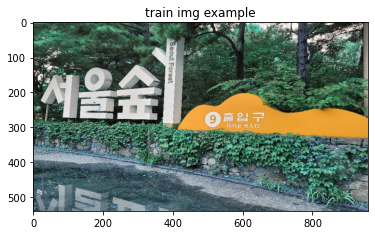

In [10]:
train_img1 = cv2.imread(all_img_path[0])
plt.title('train img example')
plt.imshow(train_img1)

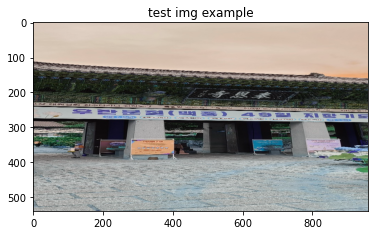

In [11]:
test_img1 = cv2.imread(test_img_path[0])
plt.title('test img example')
plt.imshow(test_img1)

## 3. Train Validation Split

In [12]:
train_len = int(len(all_img_path)*0.75)
val_len = int(len(all_img_path)*0.25)

train_img_path = all_img_path[:train_len]
train_label = all_label[:train_len]

val_img_path = all_img_path[train_len:]
val_label = all_label[train_len:]

print('train data:', train_len)
print('val data:', val_len)

train data: 542
val data: 180


## 4. Dataset DataLoader

In [13]:
class CustomDataset(Dataset):  # Dataset은 torch.utils.data의 Dataset
    def __init__(self, img_path_list, label_list, train_mode=True, transforms=None):
        self.img_path_list = img_path_list
        self.label_list = label_list
        self.train_mode = train_mode
        self.transforms = transforms
        
    def __getitem__(self, index):  # index번째 data를 return
        img_path = self.img_path_list[index]
        img = cv2.imread(img_path)
        
        if self.transforms is not None:
            img = self.transforms(img)
            
        if self.train_mode:
            label = self.label_list[index]
            return img, label
        else:
            return img
        
    def __len__(self):
        return len(self.img_path_list)

In [14]:
# transform
data_transform = transforms.Compose([transforms.ToPILImage(), # numpy배열 >> 이미지
                                      transforms.Resize([img_size, img_size]), # 이미지 사이즈 변경
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                                     ])

In [15]:
train_dataset = CustomDataset(train_img_path,
                              train_label,
                              train_mode=True,
                              transforms=data_transform
                             )
val_dataset = CustomDataset(val_img_path,
                            val_label,
                            train_mode=True,
                            transforms=data_transform
                             )
test_dataset = CustomDataset(test_img_path,
                             None,
                             train_mode=False,
                             transforms=data_transform
                            )

In [16]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          drop_last=True
                         )

val_loader = DataLoader(dataset=val_dataset,
                        batch_size=batch_size,
                        shuffle=False,
                        drop_last=True
                       )
test_loader = DataLoader(test_dataset,
                         batch_size=batch_size,
                         shuffle=False
                        )

In [17]:
train_batches = len(train_loader)
val_batches = len(val_loader)

print('total train imgs :',train_len,'/ total train batches :', train_batches)
print('total valid imgs :',val_len, '/ total valid batches :', val_batches)

total train imgs : 542 / total train batches : 33
total valid imgs : 180 / total valid batches : 11


## 5. Model

In [18]:
# input shape 확인

for X, y in train_loader:
    print(X.shape)
    break

torch.Size([16, 3, 128, 128])


In [66]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        # input shape (?, 3, 128, 128)
        self.layer1 = nn.Sequential(nn.Conv2d(3, 8, kernel_size=2, stride=1, padding=1),
                                    # shape (?, 8, 128, 128)
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2)
                                    # shape (?, 8, 64, 64)
                                   )
        # input shape (?, 8, 64, 64)
        self.layer2 = nn.Sequential(nn.Conv2d(8, 16, kernel_size=2, stride=1, padding=1),
                                    # shape (?, 16, 64, 64)
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2)
                                    # shape (?, 16, 32, 32)
                                   )
        # input shape (?, 16, 32, 32)
        self.layer3 = nn.Sequential(nn.Conv2d(16, 32, kernel_size=2, stride=1, padding=1),
                                    # shape (?, 32, 32, 32)
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2)
                                    # shaep (?, 32, 16, 16)
                                   )
        # input shape (?, 32, 16, 16)
        self.layer4 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=2, stride=1, padding=1),
                                    # shape (?, 64, 16, 16)
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2)
                                    # shape (?, 64, 8, 8)
                                   )
        
        
        # inpust shape (?, 64, 8, 8), out 10 (분류갯수)
        self.fc1 = nn.Linear(8*8*64, 10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(out.size(0), -1) # flatten
        out = self.fc1(out)
        return out

In [67]:
model = CNN()

cost = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [76]:
from torchvision import models

model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad=False

in_features=model.fc.in_features

classifier=nn.Sequential(
    nn.Linear(in_features,1024),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(1024,10),
)

model.fc=classifier

cost = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [77]:
# 총배치 및 총 훈련데이터
train_batch = len(train_loader)
val_batch = len(val_loader)
print('train batch:', train_batch, '\t total train data:', train_batch * batch_size)
print('val batch:', val_batch, '\t\t total val data:', val_batch * batch_size)

train batch: 33 	 total train data: 528
val batch: 11 		 total val data: 176


In [78]:
# train
best_acc = 0

for epoch in tqdm(range(n_epochs)):
    model.train()
    avg_cost = 0.0
    
    for X, y in train_loader: # X 미니배치, y 레이블
        
        # model
        h = model(X)
        
        # loss
        loss = cost(h, y)
        
        # update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        avg_cost += loss/len(train_loader)
        
    # val
    model.eval()
    correct = 0
    val_loss = 0.0
    
    with torch.no_grad():
        for X, y in val_loader: # X 미니배치, y 레이블

            # model
            h = model(X)

            # loss
            loss = cost(h, y)
            val_loss += loss
            
            pred = h.argmax(dim=1, keepdim=True) # 가장 높은값을 예측 label로 추출
            correct += pred.eq(y.view_as(pred)).sum().item() # 예측값과 실제값이 맞으면 1 아니면 0으로 합산

    val_acc = 100*correct/len(val_loader.dataset)
    
    if epoch%10==0:
        print(f'Epoch {epoch}/{n_epochs}\t Train Loss {avg_cost:.6f} \t Val Loss {val_loss/len(val_loader):.4f} \t Val Accuracy {val_acc:.2f}%')
        
    # best model 저장
    if best_acc < val_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), './best_model_resnet50.pth')
        print(f'{best_acc:.2f}% Model Saved')

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0/50	 Train Loss 9.033841 	 Val Loss 0.8781 	 Val Accuracy 70.72%
70.72% Model Saved
80.11% Model Saved
86.74% Model Saved
87.29% Model Saved
92.27% Model Saved
Epoch 10/50	 Train Loss 0.616319 	 Val Loss 0.3028 	 Val Accuracy 86.74%
Epoch 20/50	 Train Loss 0.723643 	 Val Loss 0.4354 	 Val Accuracy 88.40%
92.82% Model Saved
Epoch 30/50	 Train Loss 0.691765 	 Val Loss 0.3091 	 Val Accuracy 90.61%
Epoch 40/50	 Train Loss 0.598829 	 Val Loss 0.3134 	 Val Accuracy 90.06%


In [70]:
# call model
checkpoint = torch.load('./best_model.pth')
model = CNN()
model.load_state_dict(checkpoint)

# test
model.eval()
model_pred = []

with torch.no_grad():
    for img in test_loader:
        pred = model(img)
        pred = pred.argmax(dim=1, keepdim=True).squeeze(1)
        model_pred.extend(pred.tolist())
print('pred example:', model_pred)

pred example: [7, 1, 1, 7, 6, 1, 3, 6, 3, 0, 0, 7, 3, 1, 2, 3, 2, 3, 4, 8, 6, 4, 2, 0, 3, 9, 2, 9, 1, 8, 0, 8, 6, 3, 3, 2, 4, 8, 9, 2, 5, 2, 3, 8, 5, 6, 4, 3, 2, 3, 0, 4, 3, 5, 9, 3, 5, 6, 4, 0, 1, 6, 1, 5, 0, 0, 0, 2, 0, 8, 3, 4, 4, 4, 6, 4, 4, 4, 9, 5, 7, 9, 9, 4, 3, 8, 1, 0, 1, 8, 9, 0, 3, 6, 2, 5, 8, 6, 7, 7, 3, 5, 0, 9, 5, 6, 5, 9, 7, 0, 7, 8, 4, 8, 8, 5, 4, 5, 1, 5, 4, 5, 1, 6, 4, 2, 9, 8, 6, 0, 8, 7, 2, 0, 6, 3, 4, 6, 9, 7, 1, 8, 8, 5, 3, 6, 2, 6, 7, 6, 8, 3, 5, 3, 8, 5, 6, 6, 7, 5, 6, 2, 0, 6, 5, 0, 4, 2, 5, 1, 9, 7, 1, 4, 3, 3, 3, 8, 0, 4, 1, 4, 6, 7, 3, 9, 3, 2, 7, 2, 8, 7, 7, 8, 0, 1, 1, 9, 8]


In [80]:
# call model
checkpoint = torch.load('./best_model_resnet50.pth')
model = models.resnet50()
for param in model.parameters():
    param.requires_grad=False

in_features=model.fc.in_features

classifier=nn.Sequential(
    nn.Linear(in_features,1024),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(1024,10),
)

model.fc=classifier
model.load_state_dict(checkpoint)

# test
model.eval()
model_pred = []

with torch.no_grad():
    for img in test_loader:
        pred = model(img)
        pred = pred.argmax(dim=1, keepdim=True).squeeze(1)
        model_pred.extend(pred.tolist())
print('pred example:', model_pred)

pred example: [2, 1, 9, 7, 6, 1, 3, 6, 3, 1, 6, 1, 7, 1, 2, 3, 2, 0, 4, 0, 6, 4, 2, 0, 8, 9, 2, 9, 1, 8, 0, 8, 6, 3, 3, 0, 7, 8, 9, 2, 5, 4, 3, 8, 5, 6, 4, 9, 0, 3, 5, 4, 1, 5, 9, 3, 5, 6, 4, 0, 6, 6, 1, 5, 0, 9, 0, 2, 0, 8, 3, 4, 4, 4, 6, 4, 4, 2, 7, 5, 8, 9, 9, 4, 3, 0, 1, 8, 1, 8, 9, 0, 7, 6, 7, 5, 2, 6, 7, 7, 3, 5, 0, 9, 7, 6, 5, 9, 7, 0, 7, 8, 4, 8, 8, 5, 4, 5, 1, 5, 4, 5, 1, 6, 4, 8, 9, 8, 6, 0, 8, 2, 1, 8, 6, 3, 4, 6, 7, 7, 1, 8, 2, 5, 7, 6, 2, 6, 2, 6, 8, 3, 5, 7, 2, 5, 6, 6, 6, 5, 6, 2, 3, 0, 5, 9, 4, 0, 5, 1, 9, 7, 1, 4, 3, 3, 3, 8, 1, 4, 1, 4, 6, 7, 3, 9, 3, 7, 7, 2, 0, 7, 2, 8, 0, 1, 1, 9, 0]


## 6. DACON 제출

In [81]:
submission = pd.read_csv('./dataset/sample_submission.csv')
submission['label'] = model_pred
submission

,file_name,label
0,001.PNG,2
1,002.PNG,1
2,003.PNG,9
3,004.PNG,7
4,005.PNG,6
...,...,...
194,195.PNG,0
195,196.PNG,1
196,197.PNG,1
197,198.PNG,9


In [82]:
submission.to_csv('./dataset/submission_resnet50.csv', index=False)

In [83]:
# best accuracy=89.5% lr=0.01 batchsize=16 layer=4
# 제출점수 0.9090
print(model_pred)

[7, 1, 9, 7, 6, 1, 3, 6, 6, 1, 8, 1, 7, 1, 2, 3, 2, 0, 4, 0, 6, 4, 8, 0, 8, 9, 2, 9, 1, 8, 6, 8, 6, 3, 3, 8, 7, 8, 9, 2, 5, 4, 3, 8, 5, 6, 4, 9, 2, 3, 5, 4, 1, 5, 9, 3, 5, 6, 4, 0, 0, 6, 1, 5, 5, 2, 0, 2, 0, 8, 3, 4, 4, 4, 6, 4, 4, 2, 0, 5, 7, 9, 9, 4, 3, 8, 1, 9, 1, 8, 9, 0, 2, 6, 2, 5, 2, 6, 2, 7, 3, 5, 0, 9, 2, 6, 5, 9, 7, 0, 0, 2, 4, 8, 8, 5, 4, 5, 1, 5, 4, 5, 1, 6, 4, 2, 9, 8, 6, 5, 8, 2, 1, 9, 6, 3, 4, 6, 7, 7, 1, 8, 2, 5, 7, 6, 2, 6, 2, 6, 8, 3, 5, 0, 2, 5, 6, 6, 6, 5, 6, 2, 3, 0, 5, 9, 4, 2, 5, 1, 9, 7, 1, 4, 3, 3, 3, 8, 1, 4, 1, 4, 6, 7, 3, 9, 3, 2, 7, 2, 8, 7, 8, 8, 0, 1, 1, 9, 0]


In [ ]:
# resnet50 accuracy=92.82% 제출점수 0.9595